## 프로젝트 루브릭
---
- 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전 과정이 성공적으로 진행되었는가? 
-  제출된 노트북이 캐글 커널로 사용될 수 있을만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
- 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000이하의 점수를 얻었는가?

## 임포트 및 각종 옵션 설정
---

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import os
from os.path import join

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 1. 데이터 탐색  

### 1.1 데이터 불러오기
---

In [2]:
_dir = os.getenv('HOME') + '/project/aiffel-lms/E8_Kaggle_Housing/data'
train_data_path = join(_dir, 'train.csv')
test_data_path = join(_dir, 'test.csv')

df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)



print('train data shape: {}'.format(df_train.shape))
print('test data shape: {}'.format(df_test.shape))


train data shape: (15035, 21)
test data shape: (6468, 20)


### 1.2 변수 설명
---
- ID : 집을 구분하는 번호  
- date : 집을 구매한 날짜  
- price : 집의 가격(Target variable)
- bedrooms : 침실의 수
- bathrooms : 화장실의 수
- sqft_living : 주거 공간의 평방 피트(면적)
- sqft_lot : 부지의 평방 피트(면적)
- floors : 집의 층 수
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- view : Has been viewed
- condition : 집의 전반적인 상태
- grade : King County grading 시스템 기준으로 매긴 집의 등급
- sqft_above : 지하실을 제외한 평방 피트(면적)
- sqft_basement : 지하실의 평방 피트(면적)
- yr_built : 지어진 년도
- yr_renovated : 집을 재건축한 년도
- zipcode : 우편번호
- lat : 위도
- long : 경도
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
- sqft_lot15 : 2015년 기준 주차 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

In [3]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 1.2 목적 변수 시각화
---

In [4]:
df_train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

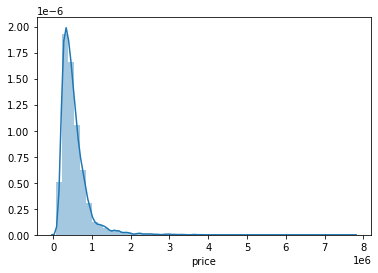

In [5]:
sns.distplot(df_train['price'])

### 1.3 목적변수 normalizing
---

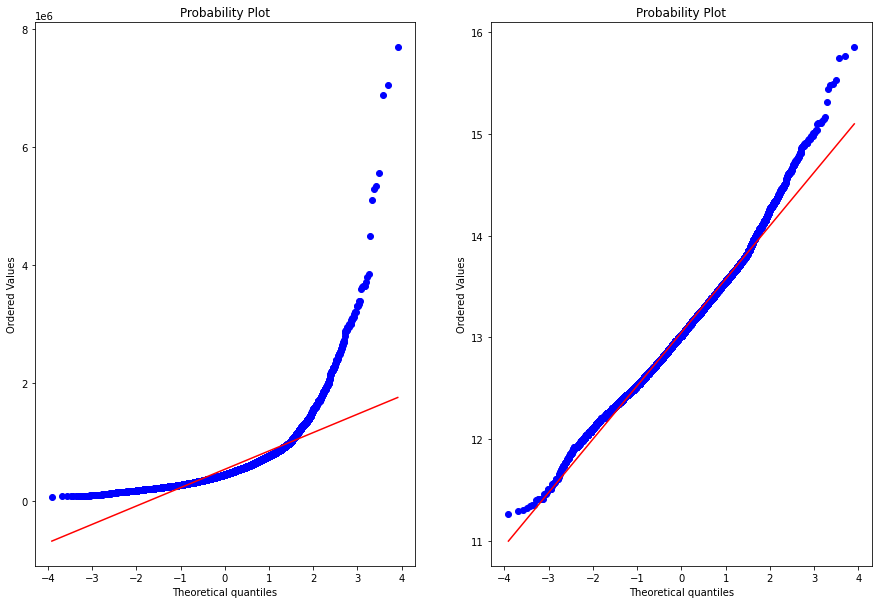

In [6]:
fig = plt.figure(figsize = (15, 10))

fig.add_subplot(1, 2, 1)
res = stats.probplot(df_train['price'], plot=plt)

fig.add_subplot(1, 2, 2)
res = stats.probplot(np.log1p(df_train['price']), plot=plt)

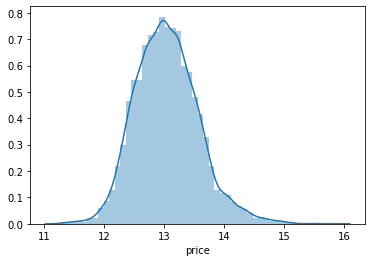

In [7]:
df_train['price'] = np.log1p(df_train['price'])
sns.distplot(df_train['price'])

### 1.4 반응변수 시각화
---

스피어만 순위 상관관계를 기준으로 목적변수와 상관도가 높은 상위 10개의 반응변수 시각화

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


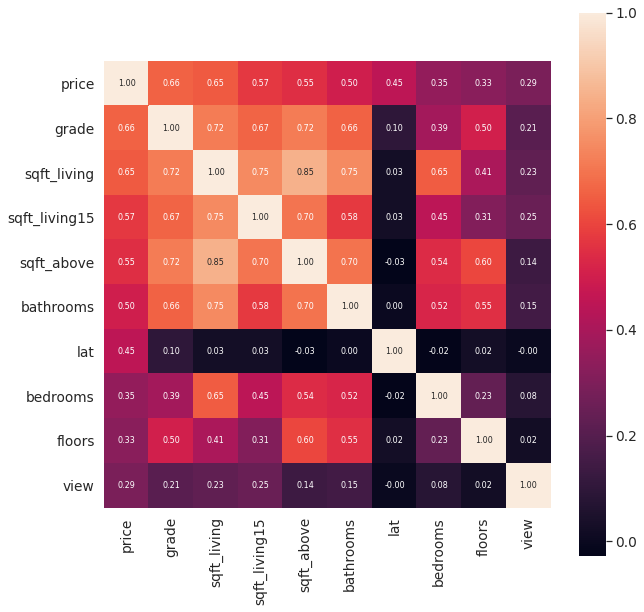

In [8]:
import scipy as sp

cor_abs = abs(df_train.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=10, columns='price').index

cor = np.array(sp.stats.spearmanr(df_train[cor_cols].values))[0]
print(cor_cols.values)

plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True, annot_kws={'size' : 8}, xticklabels=cor_cols.values, yticklabels=cor_cols.values)

## 2. 데이터 전처리

### 2.1 grade
---

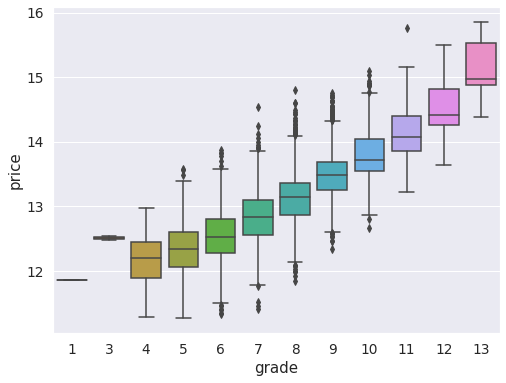

In [9]:
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x='grade', y='price', data=data)

전반적으로 선형성을 보이는 가운데, 다음 2가지를 상위 10개 항목에 비춰 살펴봄

- 등급 3의 이상치
- 등급 7, 8, 11의 높은 이상치

In [10]:
df_train.loc[(df_train['price']>12) & (df_train['grade'] == 3)][cor_cols]

,price,grade,sqft_living,sqft_living15,sqft_above,bathrooms,lat,bedrooms,floors,view
2302,12.476104,3,520,1340,520,0.75,47.2082,1,1.0,0
4123,12.542548,3,600,990,600,0.00,47.5316,1,1.0,0


In [11]:
df_train.loc[(df_train['price']>14) & (df_train['grade'] == 7)][cor_cols] 

,price,grade,sqft_living,sqft_living15,sqft_above,bathrooms,lat,bedrooms,floors,view
647,14.054528,7,3200,4090,2160,2.50,47.6209,5,1.0,0
8148,14.250535,7,2640,1910,2080,2.25,47.6313,4,2.0,0
12346,14.533351,7,3580,2410,3480,3.25,47.7087,4,1.5,4
12457,14.115616,7,2070,3000,1590,2.00,47.6160,3,1.0,1


In [12]:
df_train.loc[(df_train['price']>15) & (df_train['grade'] == 11)][cor_cols] 

,price,grade,sqft_living,sqft_living15,sqft_above,bathrooms,lat,bedrooms,floors,view
1499,15.163584,11,5770,4620,5770,4.25,47.5850,4,2.0,4
2775,15.770310,11,10040,3930,7680,4.50,47.6500,5,2.0,2
4598,15.110238,11,5480,3510,3910,4.75,47.6515,6,1.5,4
7297,15.039286,11,4260,4260,3280,4.00,47.6380,4,2.0,0
9814,15.009433,11,6200,2940,4440,4.75,47.6050,5,2.0,4
10645,15.107742,11,4830,3820,4830,3.25,47.6409,4,2.0,4
12646,15.009433,11,4220,3810,2460,3.25,47.6083,3,1.0,4
14231,15.022978,11,5350,3740,3040,3.75,47.6480,5,1.0,1


같은 등급의 다른 집들과 비교했을 때, 상위 10개 항목에서 뚜렷한 차이를 보이는 id 12346을 제외한 나머지 이상치 제거

In [13]:
df_train = df_train.loc[df_train['id'] != 2302]
df_train = df_train.loc[df_train['id'] != 4123]
df_train = df_train.loc[df_train['id'] != 2775]

### 2.2 sqft_living / sqft_living15 / sqft_above
---

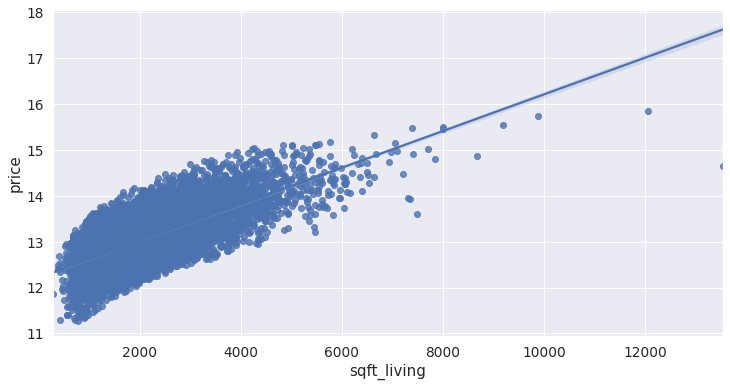

In [14]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(12,6))
fig = sns.regplot(x='sqft_living', y='price', data=data)

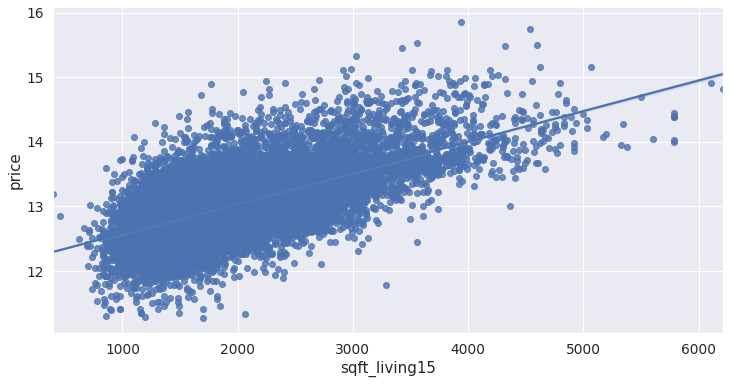

In [15]:
data = pd.concat([df_train['price'], df_train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(12,6))
fig = sns.regplot(x='sqft_living15', y='price', data=data)

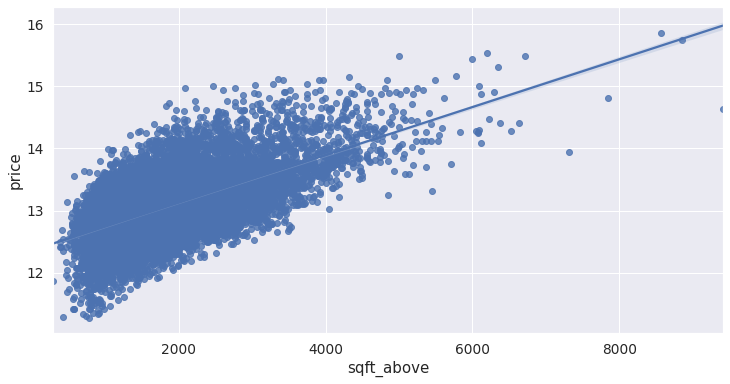

In [16]:
data = pd.concat([df_train['price'], df_train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(12,6))
fig = sns.regplot(x='sqft_above', y='price', data=data)

sqft_living > 13000 에 이상치가 하나 존재함

In [17]:
df_train.loc[df_train['sqft_living']>13000][cor_cols]

,price,grade,sqft_living,sqft_living15,sqft_above,bathrooms,lat,bedrooms,floors,view
8912,14.639686,12,13540,4850,9410,8.0,47.6675,7,3.0,4


가격에 비해 sqft_living의 값만 비정상적으로 크므로 제거

In [18]:
df_train = df_train.loc[df_train['id']!=8912]

### 2.3 결측치 확인
---

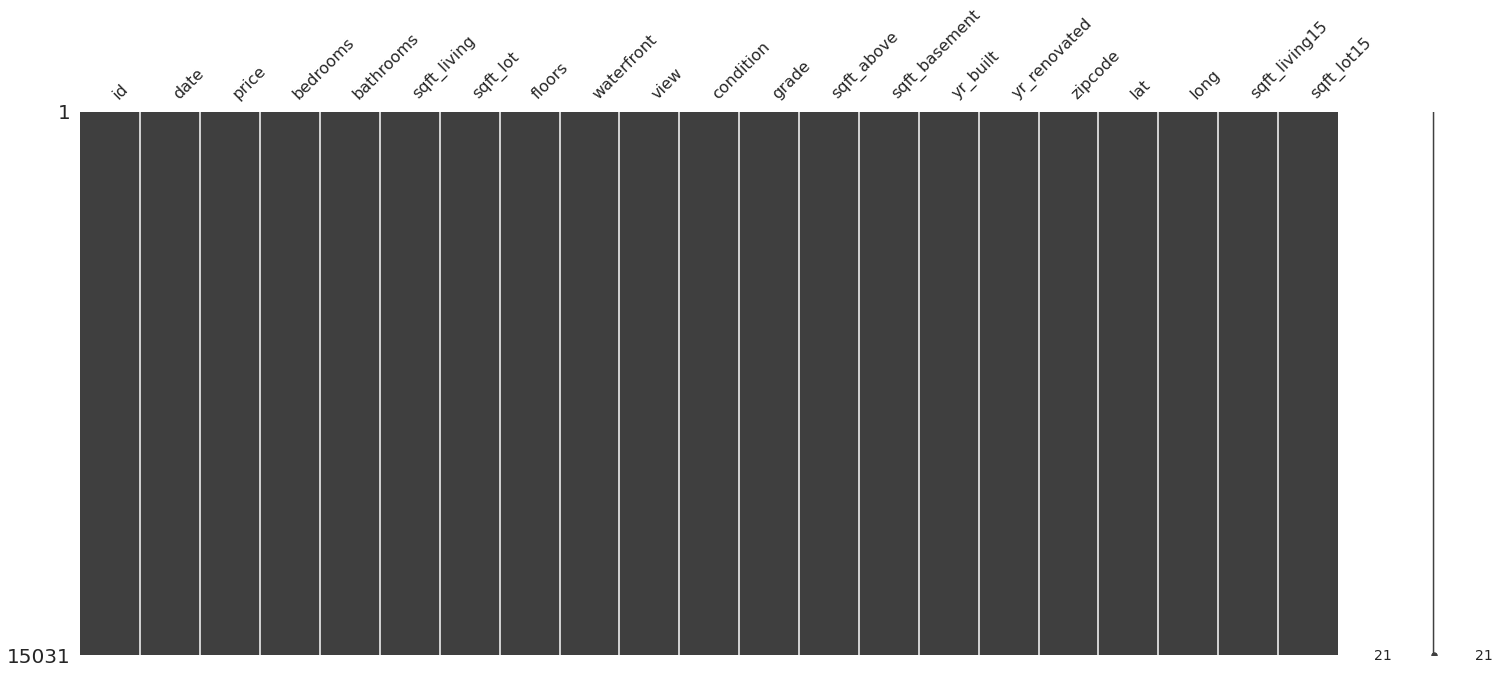

In [19]:
msno.matrix(df_train)

### 2.4 데이터 정리
---

In [20]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,12.309987,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,12.100718,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,13.142168,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,12.458779,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,12.583999,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [21]:
df_train['date'] = df_train['date'].apply(lambda x: x[:6]).astype(int)

df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,12.309987,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,12.100718,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,13.142168,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,12.458779,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,12.583999,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [22]:
y = df_train['price']
del df_train['price']

print(df_train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [23]:

del df_train['id']

print(df_train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [24]:
df_test['date'] = df_test['date'].apply(lambda i: i[:6]).astype(int)
sub_id = df_test['id']

del df_test['id']

print(df_test.columns)
print(len(sub_id))

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
6468


<function matplotlib.pyplot.show(*args, **kw)>

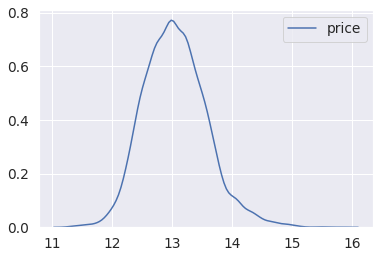

In [25]:
y

sns.kdeplot(y)
plt.show

In [26]:
print(df_train.shape)
print(df_test.shape)

(15031, 19)
(6468, 19)


## 3. 모델 설계
---

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


In [28]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]



In [29]:
def get_scores(models, train, y):
    df = {}
    # 답안 작성
    for model in models:
        model_name = model.__class__.__name__
        X_train, X_test, y_train, y_test = train_test_split(df_train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] =rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df
        
get_scores(models, df_train, y)

,RMSE
GradientBoostingRegressor,136597.421666
RandomForestRegressor,122563.424254
XGBRegressor,114115.681688
LGBMRegressor,112939.009327


## 3.1 하이퍼파라미터 튜닝

### lightGBM

In [30]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.03, 0.05, 0.1], 
    'num_iterations': [1000, 1500],
    'max_depth': [5, 10, -1],
    'boosting': ['dart', 'gbdt']
}

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

my_GridSearch(lightgbm, df_train, y, param_grid)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  5.5min
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:  5.7min finished


,boosting,learning_rate,max_depth,num_iterations,score,RMSLE
22,gbdt,0.03,-1,1000,-0.025666,0.160207
23,gbdt,0.03,-1,1500,-0.025706,0.160330
20,gbdt,0.03,10,1000,-0.025761,0.160501
21,gbdt,0.03,10,1500,-0.025774,0.160542
26,gbdt,0.05,10,1000,-0.025904,0.160948
28,gbdt,0.05,-1,1000,-0.026009,0.161273
27,gbdt,0.05,10,1500,-0.026093,0.161535
24,gbdt,0.05,5,1000,-0.026100,0.161554
19,gbdt,0.03,5,1500,-0.026129,0.161643
29,gbdt,0.05,-1,1500,-0.026168,0.161766


In [31]:
lgbm_param = {
    'learning_rate': 0.03,
    'num_iterations': 1000,
    'max_depth': -1,
    'boosting': 'gbdt'
}

### RF Regressor

In [32]:
param_grid =   {
    'n_estimators': [500, 1000, 1500],
    'bootstrap': [True, False],
    'max_depth': [10, 15],
}

my_GridSearch(rdforest, df_train, y, param_grid)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  5.4min
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed: 12.4min finished


,bootstrap,max_depth,n_estimators,score,RMSLE
5,True,15,1500,-0.031634,0.177860
4,True,15,1000,-0.031646,0.177892
3,True,15,500,-0.031703,0.178055
2,True,10,1500,-0.034767,0.186459
1,True,10,1000,-0.034777,0.186486
0,True,10,500,-0.034790,0.186521
7,False,10,1000,-0.049476,0.222433
8,False,10,1500,-0.049478,0.222436
6,False,10,500,-0.049482,0.222446
10,False,15,1000,-0.056235,0.237139


In [33]:
rf_param = {
    'n_estimators': 1500,
    'bootstrap': True,
    'max_depth': 15
}

### XGBoost

In [34]:
param_grid = {
    'eta': [0.03, 0.05, 0.1],
    'nrounds': [1000, 1500],
    'max_depth': [-1, 5, 10],
    'booster': ['gblinear', 'gbtree', 'dart']
}

my_GridSearch(xgboost, df_train, y, param_grid)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 167 tasks      | elapsed:   11.5s
[Parallel(n_jobs=5)]: Done 270 out of 270 | elapsed:   44.6s finished


[17:16:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,booster,eta,max_depth,nrounds,score,RMSLE
38,dart,0.03,5,1000,-0.028416,0.168570
51,dart,0.10,5,1500,-0.028416,0.168570
50,dart,0.10,5,1000,-0.028416,0.168570
45,dart,0.05,5,1500,-0.028416,0.168570
44,dart,0.05,5,1000,-0.028416,0.168570
39,dart,0.03,5,1500,-0.028416,0.168570
21,gbtree,0.03,5,1500,-0.028472,0.168736
20,gbtree,0.03,5,1000,-0.028472,0.168736
27,gbtree,0.05,5,1500,-0.028472,0.168736
32,gbtree,0.10,5,1000,-0.028472,0.168736


In [35]:
xgboost_param = {
    'eta': 0.03,
    'nrounds': 1000,
    'max_depth': 5,
    'booster': 'dart'
}

### GBoost

In [36]:
param_grid = {
    'n_estimators': [100, 500, 1000, 1500],
    'max_depth': [-1, 3, 5, 7, 10],
}

my_GridSearch(gboost, df_train, y, param_grid)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  8.4min finished


,max_depth,n_estimators,score,RMSLE
9,5,500,-0.026729,0.163489
7,3,1500,-0.026764,0.163596
6,3,1000,-0.026826,0.163787
10,5,1000,-0.026922,0.164079
11,5,1500,-0.027275,0.165153
13,7,500,-0.027337,0.165339
5,3,500,-0.027481,0.165773
14,7,1000,-0.027551,0.165985
12,7,100,-0.027593,0.166110
15,7,1500,-0.027640,0.166254


In [38]:
gboost_param = {
    'n_estimators': 500,
    'max_depth': 5
}

## 3.2 앙상블

In [ ]:

gboost = GradientBoostingRegressor(n_estimators=500, max_depth=5,random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(learning_rate=0.03, num_iterations=1000, max_depth=-1, random_state=random_state)
rdforest = RandomForestRegressor(n_estimators=1500, bootstrap=True, max_depth=15, random_state=random_state)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}, {'model':rdforest, 'name':'RandomForest'}]


In [ ]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=random_state).get_n_splits(df_train.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], df_train.values, y)),
                                                  kf=kfold))


In [42]:
get_cv_score(models)

Model GradientBoosting CV score : 0.9035
Model XGBoost CV score : 0.8968
Model LightGBM CV score : 0.9073
Model RandomForest CV score : 0.8857


In [43]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [48]:
y_pred = AveragingBlending(models, df_train, y, df_test)
print(len(y_pred))
y_pred = np.expm1(y_pred)
y_pred

6468


array([ 501226.45260594,  481923.26732677, 1364209.2560458 , ...,
        472954.44936203,  320103.55101348,  434308.52701063])

## 4. 제출파일 저장

In [49]:
data_dir = os.getenv('HOME')+'/project/aiffel-lms/E8_Kaggle_Housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()




,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [50]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.012265e+05
1,15036,4.819233e+05
2,15037,1.364209e+06
3,15038,2.983499e+05
4,15039,3.282120e+05


In [51]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/home/aiffel0042/project/aiffel-lms/E8_Kaggle_Housing/data/submission.csv
